In [1]:
import numpy as np
from scipy.signal import argrelmax
import glob
import rasterio
import rasterio.features
import rasterio.warp
import classify_dms
import matplotlib.pyplot as plt

In [2]:
floc = './input/'
fname = 'DMS_1281707_14945_20111013_19064735.tif'
fname_short = fname[:-4]

In [3]:
ds = rasterio.open(floc+fname)
red = ds.read(1)
red = np.double(red)
red[red == 0] = np.nan
red = red/255
#Get green and blue bands for plotting
green = ds.read(2)
green = np.double(green)
green[green == 0] = np.nan
green = green/255
blue = ds.read(3)
blue = np.double(blue)
blue[blue == 0] = np.nan
blue = blue/255

In [4]:
hist,bins,maxima,minima = classify_dms.band_hist(red)

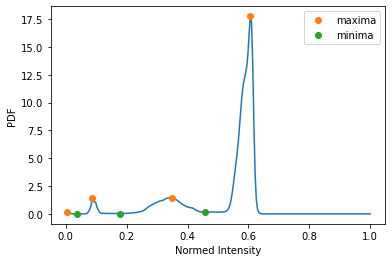

In [5]:
x = np.linspace(0, 1, num=255) #255 samples per image
plt.plot(x,hist)
plt.plot(maxima/255,hist[maxima],'o',label = 'maxima')
plt.plot(minima/255,hist[minima],'o',label = 'minima')
plt.ylabel('PDF')
plt.xlabel('Normed Intensity')
plt.legend()
plt.show()

In [6]:
red_classed = classify_dms.class_from_hist(red,minima,maxima)

[Plotting large .tif files may take a moment]
Plotting RGB image...
Plotting Classified image...


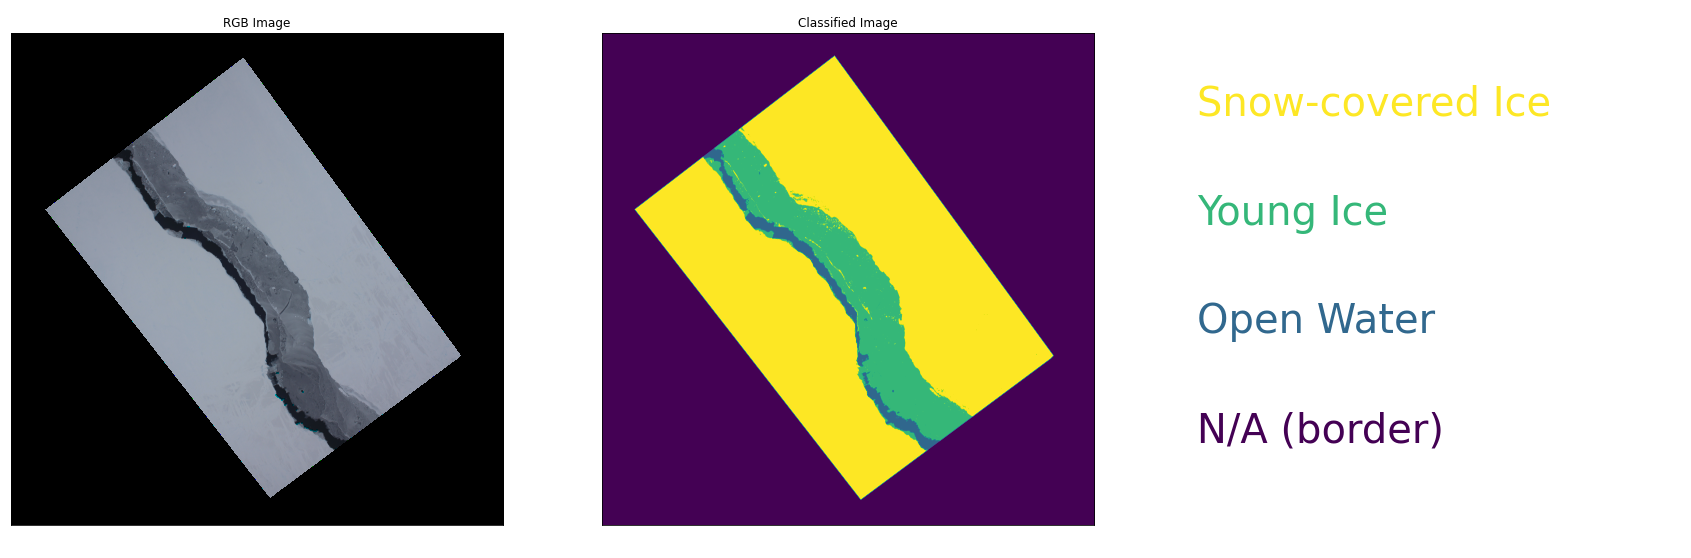

In [7]:
import matplotlib
fig,ax = plt.subplots(1,3,figsize=(30, 10))

print('[Plotting large .tif files may take a moment]')
print('Plotting RGB image...')

#Plot RGB Image first
rgb = np.stack((red,green,blue),axis=2)
ax[0].imshow(rgb)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].set_title('RGB Image')

print('Plotting Classified image...')

#Plot Classified
cmap = matplotlib.cm.get_cmap('viridis')
im = ax[1].imshow(red_classed,cmap=cmap)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_title('Classified Image')

#Make Legend
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
ax[2].axes.xaxis.set_visible(False)
ax[2].axes.yaxis.set_visible(False)
ax[2].text(.01,.8,'Snow-covered Ice',fontsize=40,c=cmap(norm(3)))
ax[2].text(.01,.6,'Young Ice',fontsize=40,c=cmap(norm(2)))
ax[2].text(.01,.4,'Open Water',fontsize=40,c=cmap(norm(1)))
ax[2].text(.01,.2,'N/A (border)',fontsize=40,c=cmap(norm(0)))
ax[2].axis('off')
plt.show()

In [8]:
#Save the classified image
output_dir = './output/'
with rasterio.open(
    output_dir+fname_short+'_classified.tif',
    'w',
    driver='GTiff',
    height=red_classed.shape[0],  
    width=red_classed.shape[1],
    count=1,
    dtype=red_classed.dtype,
    crs=ds.crs, #'EPSG:4326',
    transform=ds.transform,
) as dst:
    dst.write(red_classed, 1)